In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import os 
import numpy as np
import random



In [2]:
def set_seed(seed=42):
    """Set the random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()

        # Encoder (Downsampling)
        self.encoder = nn.Sequential(
            self.conv_block(in_channels, 64),
            self.conv_block(64, 128),
            self.conv_block(128, 256),
            self.conv_block(256, 512),
            self.conv_block(512, 1024)
        )

        # Decoder (Upsampling)
        self.decoder = nn.Sequential(
            self.upconv_block(1024, 512),
            self.upconv_block(512, 256),
            self.upconv_block(256, 128),
            self.upconv_block(128, 64),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder[0](x)
        enc2 = self.encoder[1](enc1)
        enc3 = self.encoder[2](enc2)
        enc4 = self.encoder[3](enc3)
        enc5 = self.encoder[4](enc4)

        # Decoder
        dec1 = self.decoder[0](enc5)
        dec2 = self.decoder[1](dec1 + enc4)
        dec3 = self.decoder[2](dec2 + enc3)
        dec4 = self.decoder[3](dec3 + enc2)
        out = self.decoder[4](dec4 + enc1)

        return out


In [4]:
# Load CelebA dataset with a subset of 10,000 images
dataset = datasets.CelebA(
    root="./data",
    split="train",
    download=True,
    transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
)
subset_indices = list(range(10000))  # Select first 10,000 images
subset_dataset = Subset(dataset, subset_indices)
dataloader = DataLoader(subset_dataset, batch_size=8, shuffle=True)


Files already downloaded and verified


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize U-Net model
unet = UNet().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0002)

In [6]:

def create_mask(images, mask_type="random"):
    """
    Generate a mask that blocks large contiguous regions of the face.
    
    mask_type:
    - "top" -> Blocks the top half of the image
    - "bottom" -> Blocks the bottom half of the image
    - "left" -> Blocks the left half of the image
    - "right" -> Blocks the right half of the image
    - "random" -> Blocks a random square region
    """
    batch_size, channels, height, width = images.size()
    mask = torch.ones(batch_size, channels, height, width, device=device)

    for i in range(batch_size):
        if mask_type == "top":
            mask[i, :, :height//2, :] = 0  # Mask top half
        elif mask_type == "bottom":
            mask[i, :, height//2:, :] = 0  # Mask bottom half
        elif mask_type == "left":
            mask[i, :, :, :width//2] = 0  # Mask left half
        elif mask_type == "right":
            mask[i, :, :, width//2:] = 0  # Mask right half
        elif mask_type == "random":
            # Create a random square mask
            size = random.randint(height//3, height//2)  # Random block size
            x = random.randint(0, height - size)
            y = random.randint(0, width - size)
            mask[i, :, x:x+size, y:y+size] = 0  # Apply random block mask

    return mask


In [7]:
# List to store losses
losses = []

In [8]:
# Use large block mask instead of random pixel masking
mask_type = "random"  # Change to "top", "bottom", "left", "right", or "random"

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(500):  
    epoch_loss = 0
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        
        mask = create_mask(imgs, mask_type=mask_type)  # Use large block mask
        masked_imgs = imgs * mask  # Apply mask to input images
        
        optimizer.zero_grad()
        outputs = unet(masked_imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(dataloader)
    losses.append(avg_epoch_loss)
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"face_reconstuction_epoch_{epoch+1}.pkl")
        torch.save(unet.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")



Checkpoint saved at checkpoints\face_reconstuction_epoch_10.pkl
Checkpoint saved at checkpoints\face_reconstuction_epoch_20.pkl
Checkpoint saved at checkpoints\face_reconstuction_epoch_30.pkl
Checkpoint saved at checkpoints\face_reconstuction_epoch_40.pkl
Checkpoint saved at checkpoints\face_reconstuction_epoch_50.pkl
Checkpoint saved at checkpoints\face_reconstuction_epoch_60.pkl
Checkpoint saved at checkpoints\face_reconstuction_epoch_70.pkl
Checkpoint saved at checkpoints\face_reconstuction_epoch_80.pkl
Checkpoint saved at checkpoints\face_reconstuction_epoch_90.pkl
Checkpoint saved at checkpoints\face_reconstuction_epoch_100.pkl
Checkpoint saved at checkpoints\face_reconstuction_epoch_110.pkl
Checkpoint saved at checkpoints\face_reconstuction_epoch_120.pkl
Checkpoint saved at checkpoints\face_reconstuction_epoch_130.pkl
Checkpoint saved at checkpoints\face_reconstuction_epoch_140.pkl
Checkpoint saved at checkpoints\face_reconstuction_epoch_150.pkl
Checkpoint saved at checkpoints\fa

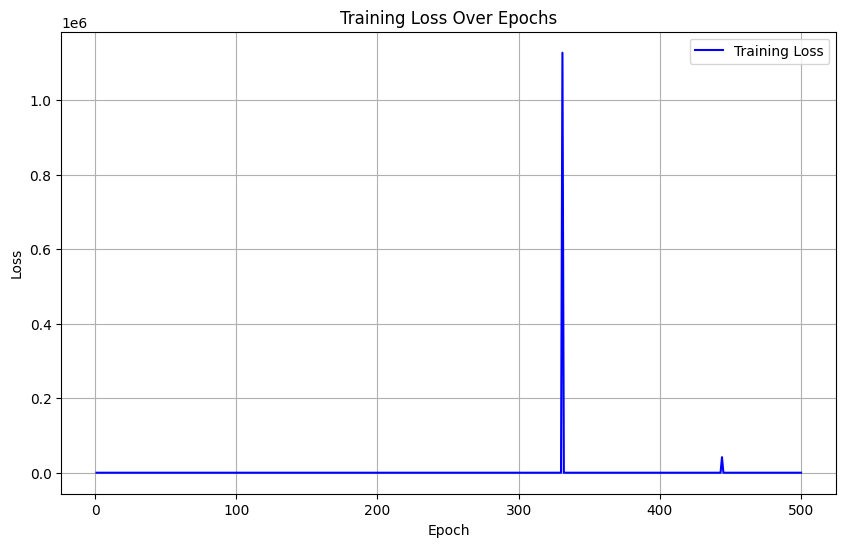

In [9]:
# Plot the loss graph after training
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, label='Training Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

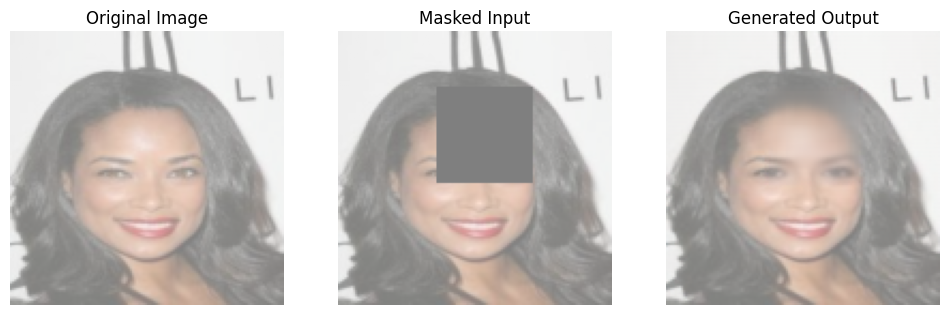

In [30]:
def show_example(unet, dataloader, device, mask_type="random"):
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)

    mask = create_mask(imgs, mask_type=mask_type)
    masked_imgs = imgs * mask

    with torch.no_grad():
        generated_imgs = unet(masked_imgs)

    def denorm(img):
        return (img * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

    idx = 0  # Select the first image from the batch
    original = denorm(imgs[idx].cpu().permute(1, 2, 0))
    masked = denorm(masked_imgs[idx].cpu().permute(1, 2, 0))
    generated = denorm(generated_imgs[idx].cpu().permute(1, 2, 0))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(original.numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(masked.numpy())
    axes[1].set_title("Masked Input")
    axes[1].axis("off")

    axes[2].imshow(generated.numpy())
    axes[2].set_title("Generated Output")
    axes[2].axis("off")

    plt.show()

# Run the function to visualize an example
show_example(unet, dataloader, device, mask_type="random") 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


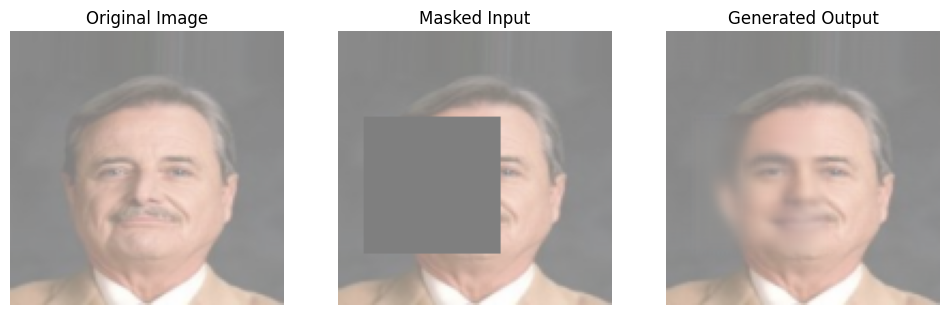

In [31]:
def show_example(unet, dataloader, device, mask_type="random"):
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)

    mask = create_mask(imgs, mask_type=mask_type)
    masked_imgs = imgs * mask

    with torch.no_grad():
        generated_imgs = unet(masked_imgs)

    def denorm(img):
        return (img * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

    idx = 0  # Select the first image from the batch
    original = denorm(imgs[idx].cpu().permute(1, 2, 0))
    masked = denorm(masked_imgs[idx].cpu().permute(1, 2, 0))
    generated = denorm(generated_imgs[idx].cpu().permute(1, 2, 0))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(original.numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(masked.numpy())
    axes[1].set_title("Masked Input")
    axes[1].axis("off")

    axes[2].imshow(generated.numpy())
    axes[2].set_title("Generated Output")
    axes[2].axis("off")

    plt.show()

# Run the function to visualize an example
show_example(unet, dataloader, device, mask_type="random") 

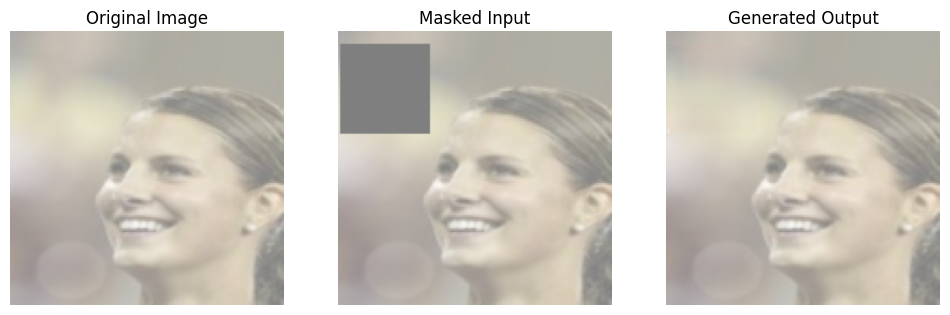

In [32]:
def show_example(unet, dataloader, device, mask_type="random"):
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)

    mask = create_mask(imgs, mask_type=mask_type)
    masked_imgs = imgs * mask

    with torch.no_grad():
        generated_imgs = unet(masked_imgs)

    def denorm(img):
        return (img * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

    idx = 0  # Select the first image from the batch
    original = denorm(imgs[idx].cpu().permute(1, 2, 0))
    masked = denorm(masked_imgs[idx].cpu().permute(1, 2, 0))
    generated = denorm(generated_imgs[idx].cpu().permute(1, 2, 0))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(original.numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(masked.numpy())
    axes[1].set_title("Masked Input")
    axes[1].axis("off")

    axes[2].imshow(generated.numpy())
    axes[2].set_title("Generated Output")
    axes[2].axis("off")

    plt.show()

# Run the function to visualize an example
show_example(unet, dataloader, device, mask_type="random") 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


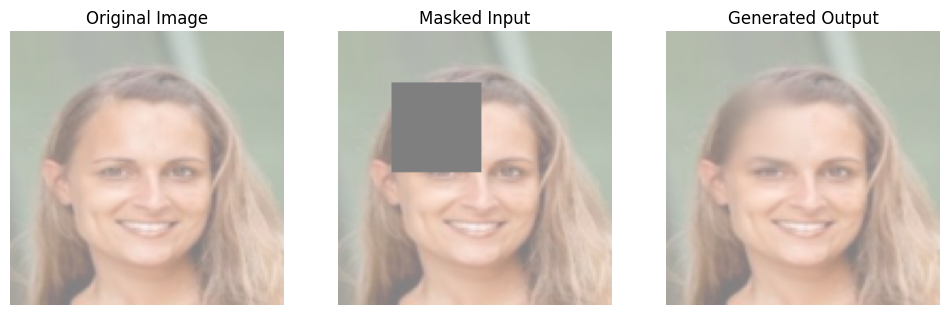

In [33]:
def show_example(unet, dataloader, device, mask_type="random"):
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)

    mask = create_mask(imgs, mask_type=mask_type)
    masked_imgs = imgs * mask

    with torch.no_grad():
        generated_imgs = unet(masked_imgs)

    def denorm(img):
        return (img * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

    idx = 0  # Select the first image from the batch
    original = denorm(imgs[idx].cpu().permute(1, 2, 0))
    masked = denorm(masked_imgs[idx].cpu().permute(1, 2, 0))
    generated = denorm(generated_imgs[idx].cpu().permute(1, 2, 0))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(original.numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(masked.numpy())
    axes[1].set_title("Masked Input")
    axes[1].axis("off")

    axes[2].imshow(generated.numpy())
    axes[2].set_title("Generated Output")
    axes[2].axis("off")

    plt.show()

# Run the function to visualize an example
show_example(unet, dataloader, device, mask_type="random") 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


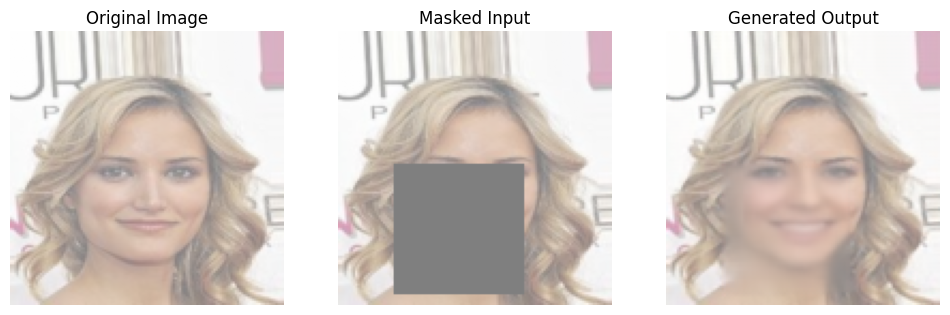

In [34]:
def show_example(unet, dataloader, device, mask_type="random"):
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)

    mask = create_mask(imgs, mask_type=mask_type)
    masked_imgs = imgs * mask

    with torch.no_grad():
        generated_imgs = unet(masked_imgs)

    def denorm(img):
        return (img * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

    idx = 0  # Select the first image from the batch
    original = denorm(imgs[idx].cpu().permute(1, 2, 0))
    masked = denorm(masked_imgs[idx].cpu().permute(1, 2, 0))
    generated = denorm(generated_imgs[idx].cpu().permute(1, 2, 0))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(original.numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(masked.numpy())
    axes[1].set_title("Masked Input")
    axes[1].axis("off")

    axes[2].imshow(generated.numpy())
    axes[2].set_title("Generated Output")
    axes[2].axis("off")

    plt.show()

# Run the function to visualize an example
show_example(unet, dataloader, device, mask_type="random") 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


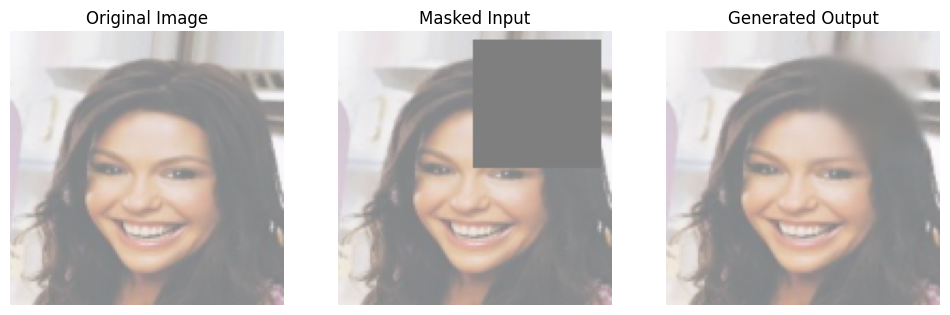

In [35]:
def show_example(unet, dataloader, device, mask_type="random"):
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)

    mask = create_mask(imgs, mask_type=mask_type)
    masked_imgs = imgs * mask

    with torch.no_grad():
        generated_imgs = unet(masked_imgs)

    def denorm(img):
        return (img * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

    idx = 0  # Select the first image from the batch
    original = denorm(imgs[idx].cpu().permute(1, 2, 0))
    masked = denorm(masked_imgs[idx].cpu().permute(1, 2, 0))
    generated = denorm(generated_imgs[idx].cpu().permute(1, 2, 0))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(original.numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(masked.numpy())
    axes[1].set_title("Masked Input")
    axes[1].axis("off")

    axes[2].imshow(generated.numpy())
    axes[2].set_title("Generated Output")
    axes[2].axis("off")

    plt.show()

# Run the function to visualize an example
show_example(unet, dataloader, device, mask_type="random") 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


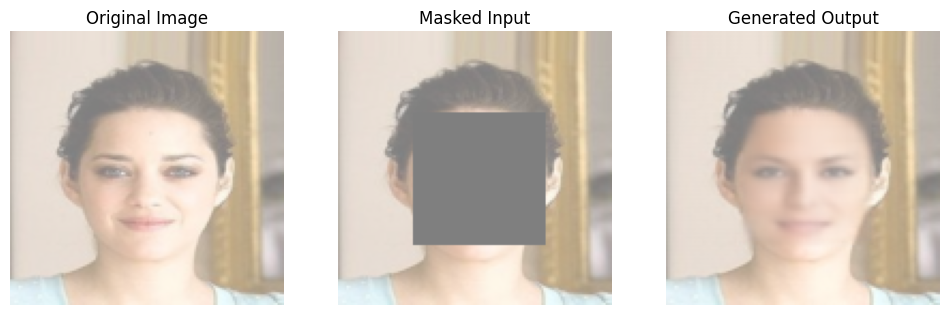

In [36]:
def show_example(unet, dataloader, device, mask_type="random"):
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)

    mask = create_mask(imgs, mask_type=mask_type)
    masked_imgs = imgs * mask

    with torch.no_grad():
        generated_imgs = unet(masked_imgs)

    def denorm(img):
        return (img * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

    idx = 0  # Select the first image from the batch
    original = denorm(imgs[idx].cpu().permute(1, 2, 0))
    masked = denorm(masked_imgs[idx].cpu().permute(1, 2, 0))
    generated = denorm(generated_imgs[idx].cpu().permute(1, 2, 0))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(original.numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(masked.numpy())
    axes[1].set_title("Masked Input")
    axes[1].axis("off")

    axes[2].imshow(generated.numpy())
    axes[2].set_title("Generated Output")
    axes[2].axis("off")

    plt.show()

# Run the function to visualize an example
show_example(unet, dataloader, device, mask_type="random") 

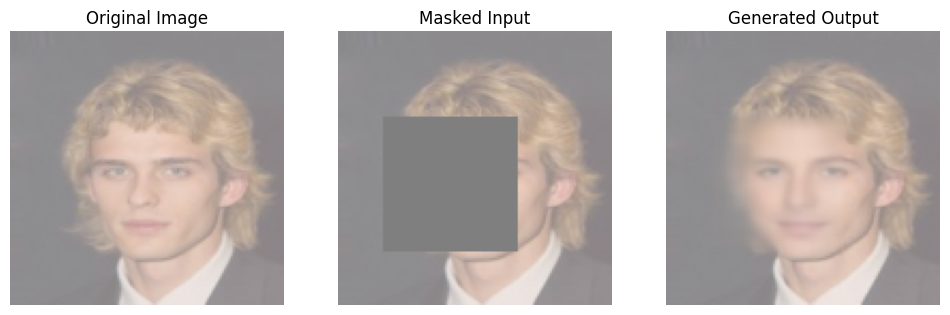

In [37]:
def show_example(unet, dataloader, device, mask_type="random"):
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)

    mask = create_mask(imgs, mask_type=mask_type)
    masked_imgs = imgs * mask

    with torch.no_grad():
        generated_imgs = unet(masked_imgs)

    def denorm(img):
        return (img * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

    idx = 0  # Select the first image from the batch
    original = denorm(imgs[idx].cpu().permute(1, 2, 0))
    masked = denorm(masked_imgs[idx].cpu().permute(1, 2, 0))
    generated = denorm(generated_imgs[idx].cpu().permute(1, 2, 0))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(original.numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(masked.numpy())
    axes[1].set_title("Masked Input")
    axes[1].axis("off")

    axes[2].imshow(generated.numpy())
    axes[2].set_title("Generated Output")
    axes[2].axis("off")

    plt.show()

# Run the function to visualize an example
show_example(unet, dataloader, device, mask_type="random") 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


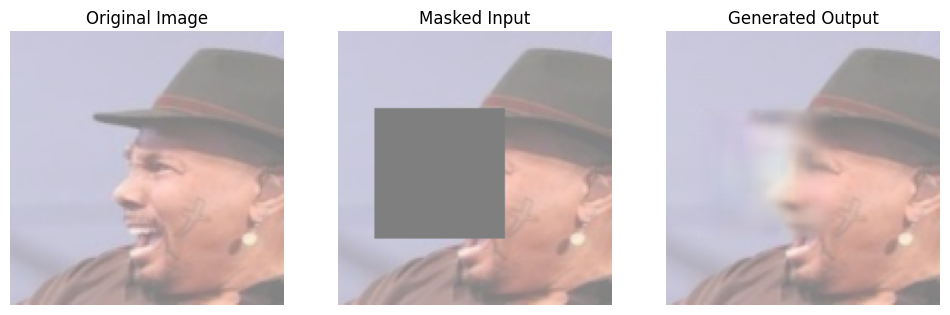

In [38]:
def show_example(unet, dataloader, device, mask_type="random"):
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)

    mask = create_mask(imgs, mask_type=mask_type)
    masked_imgs = imgs * mask

    with torch.no_grad():
        generated_imgs = unet(masked_imgs)

    def denorm(img):
        return (img * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

    idx = 0  # Select the first image from the batch
    original = denorm(imgs[idx].cpu().permute(1, 2, 0))
    masked = denorm(masked_imgs[idx].cpu().permute(1, 2, 0))
    generated = denorm(generated_imgs[idx].cpu().permute(1, 2, 0))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(original.numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(masked.numpy())
    axes[1].set_title("Masked Input")
    axes[1].axis("off")

    axes[2].imshow(generated.numpy())
    axes[2].set_title("Generated Output")
    axes[2].axis("off")

    plt.show()

# Run the function to visualize an example
show_example(unet, dataloader, device, mask_type="random") 

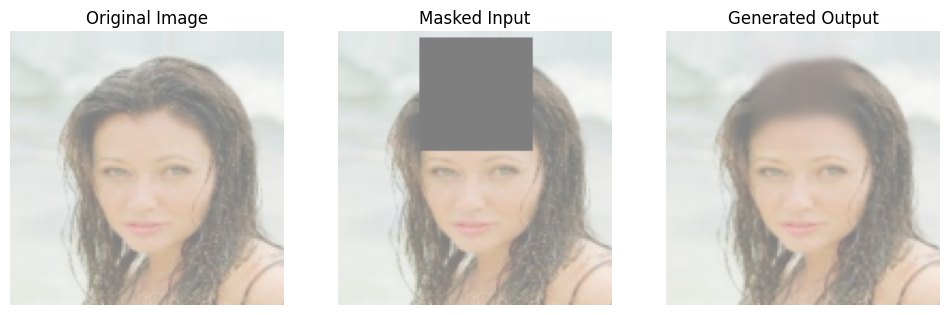

In [39]:
def show_example(unet, dataloader, device, mask_type="random"):
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)

    mask = create_mask(imgs, mask_type=mask_type)
    masked_imgs = imgs * mask

    with torch.no_grad():
        generated_imgs = unet(masked_imgs)

    def denorm(img):
        return (img * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

    idx = 0  # Select the first image from the batch
    original = denorm(imgs[idx].cpu().permute(1, 2, 0))
    masked = denorm(masked_imgs[idx].cpu().permute(1, 2, 0))
    generated = denorm(generated_imgs[idx].cpu().permute(1, 2, 0))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(original.numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(masked.numpy())
    axes[1].set_title("Masked Input")
    axes[1].axis("off")

    axes[2].imshow(generated.numpy())
    axes[2].set_title("Generated Output")
    axes[2].axis("off")

    plt.show()

# Run the function to visualize an example
show_example(unet, dataloader, device, mask_type="random") 

In [11]:
# Save the model as a pickle file
name = "face_reconstruction.pkl"
torch.save(unet.state_dict(), name)
print(f"Model saved as {name}")

Model saved as face_reconstruction.pkl


In [29]:
torch.save(unet.state_dict(), "face_reconstruction_test.pt")

In [40]:
torch.save(unet.state_dict(), 'test_test.pt', _use_new_zipfile_serialization=False)

In [41]:
path = "unet.pth"
torch.save(unet, path)